# 30_file_type_preprocessing_index_pipeline
In Memory 

https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline

Working

In [1]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

In [2]:
#!pip install markdown-it-py mdit_plain pypdf

In [3]:
document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf", "text/markdown"])
text_file_converter = TextFileToDocument()
markdown_converter = MarkdownToDocument()
pdf_converter = PyPDFToDocument()
document_joiner = DocumentJoiner()

In [4]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50)

In [5]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

In [6]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=markdown_converter, name="markdown_converter")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

In [7]:
preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("file_type_router.text/markdown", "markdown_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
preprocessing_pipeline.connect("markdown_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

🚅 Components
  - file_type_router: FileTypeRouter
  - text_file_converter: TextFileToDocument
  - markdown_converter: MarkdownToDocument
  - pypdf_converter: PyPDFToDocument
  - document_joiner: DocumentJoiner
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.text/plain -> text_file_converter.sources (List[Path])
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - file_type_router.text/markdown -> markdown_converter.sources (List[Path])
  - text_file_converter.documents -> document_joiner.documents (List[Document])
  - markdown_converter.documents -> document_joiner.documents (List[Document])
  - pypdf_converter.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.docume

In [8]:
from pathlib import Path
data_dir = "/opt/data/samples"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(data_dir).glob("**/*"))}})

Could not read /opt/data/samples/COMPREHENSIVE_ANNUAL_FINANCIAL_REPORT_CAFR_2017-18.pdf and convert it to Document, skipping. cryptography>=3.1 is required for AES algorithm


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 258}}

In [9]:
import os
from getpass import getpass

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")

Enter Hugging Face token: ········


In [12]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""
pipe = Pipeline()
pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pb = PromptBuilder(template=template)
pipe.add_component("prompt_builder", pb)
pipe.add_component("llm", HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.1"))

pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")


🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceTGIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [16]:
dir(pb)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__haystack_added_to_pipeline__',
 '__haystack_input__',
 '__haystack_is_greedy__',
 '__haystack_output__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_template_string',
 'run',
 'template',
 'to_dict']

In [18]:
pb.template.render

<bound method Template.render of <Template memory:7fe493e83160>>

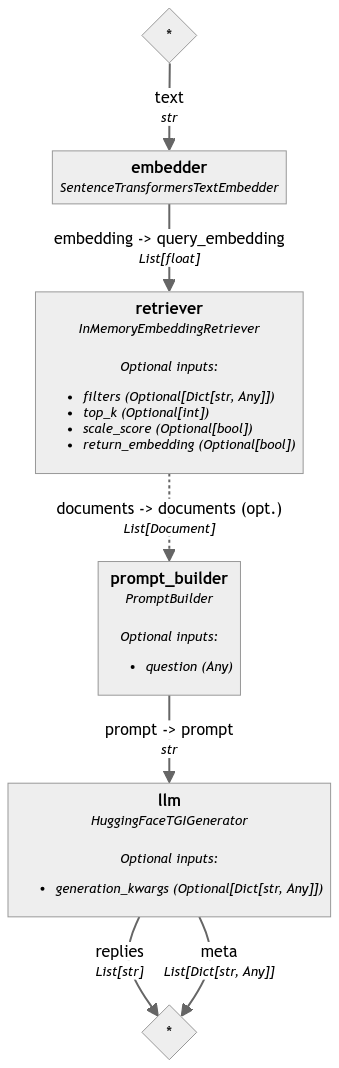

In [20]:
pipe.show()

In [11]:
question = (
    # "What topics are discussed in jacksonville politics?"
    "What are some Action Based Groups in jacksonville?"
)

pipe.run(
    {
        "embedder": {"text": question},
        "prompt_builder": {"question": question},
        "llm": {"generation_kwargs": {"max_new_tokens": 350}},
    }
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'llm': {'replies': [" There are several action-based groups in Jacksonville that focus on various issues and causes. Here are a few examples:\n\n1. Jacksonville Area Legal Aid (JALA) - JALA provides free legal services to low-income individuals and families in Jacksonville and surrounding areas. They offer assistance with a wide range of legal issues, including housing, employment, and family law.\n2. Jacksonville Community Action Partnership (JCAP) - JCAP is a nonprofit organization that provides a variety of services to low-income families and individuals in Jacksonville. They offer assistance with housing, employment, and education, as well as counseling and other support services.\n3. Jacksonville Area Rape Crisis Center (JARCC) - JARCC provides support and resources to victims of sexual assault and their families in Jacksonville and surrounding areas. They offer counseling, support groups, and other services to help victims heal and recover.\n4. Jacksonville Area Women's Crisis C